## Install dependencies

In [1]:
!pip install optuna joblib  ta
!pip install backtesting
!pip install xgboost

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.8/362.8 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.5 MB/s eta 0:00:00
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=4593e2c9e454adb92ea9d73d542c1e1c9d896dad2c0efd5b01019bc73fa691ac
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173913 sha256=cef58db011ffc52037fe9d496b88d7bffaec4818fb278281ab245cddb55ac3cf
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [2]:
!pip install --upgrade pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=e0411ce16dc4f743d81393179255bea5e0503634519f1740cfb429e46545e286
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [3]:
from datetime import datetime, timedelta, timezone
import pandas as pd
import numpy as np
import requests
import os
import logging
import sys
import optuna
import joblib
import xgboost as xgb

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
from ta import add_all_ta_features
import pandas_ta as ta

In [5]:
import matplotlib.pyplot as plt
import matplotlib

## Formulas

In [6]:
def choose_position(roi, trade_threshold = 0.0005):
    pos =0
    # Predict position base on change in future
    if roi > trade_threshold:
        pos = 1
    elif roi < -trade_threshold:
        pos = -1
    else:
        pos = 0

    return pos

In [7]:
def backtest_position_ps(position, price, percentage, periods):
    # Shift positions to align with future price changes and handle NaN by filling with 0
    pos = pd.Series(position, index=pd.Series(price).index).shift(1).fillna(0)
    pos = pd.Series(pos).rolling(periods).sum() #pos for 10 hour predict

    price_array = pd.Series(price).shift(1).fillna(0)

    pos_diff = pos.diff()
    fee = pos_diff*price_array*0.05*0.01

    # Calculate price changes over the given periods
    ch = pd.Series(price) - price_array

    # Calculate total PnL
    total_pnl = pos*ch - fee
    return total_pnl

In [8]:
def calculate_sharpe_ratio(pnl):
    pnl = np.diff(pnl)
    std = np.std(pnl) if np.std(pnl) != 0 else 0.001
    sharpe = np.mean(pnl)/std*np.sqrt(252)
    return sharpe

In [9]:
def sharpe_for_vn30f(y_pred, y_price, trade_threshold, fee_perc, periods):

    # Predict position base on change in future
    pos = [choose_position(roi, trade_threshold) for roi in y_pred]
    pos = np.array(pos)

    # Calculate PNL
    pnl = backtest_position_ps(pos, y_price, fee_perc, periods)
    pnl = np.cumsum(pnl)

    # Standardalize PNL to date
    daily_pnl = [pnl.iloc[i] for i in range(0, len(pnl), 241)]
    daily_pnl = pd.Series(daily_pnl).fillna(0)

    # Calculate Sharpe
    sharpe = calculate_sharpe_ratio(daily_pnl)

    return pos, pnl, daily_pnl, sharpe

In [10]:
def calculate_hitrate(pos_predict, pos_true):
    if len(pos_predict) != len(pos_true):
        raise ValueError("Độ dài của hai mảng không khớp")

    # Tính số lượng dự đoán đúng (các phần tử tương ứng giống nhau)
    correct_predictions = np.sum(pos_predict == pos_true)

    # Tính tỷ lệ hit rate
    hit_rate_value = correct_predictions / len(pos_predict)

    return hit_rate_value

# Function for data

In [11]:
def scale_data(data):
    index = data.index
    scaler = StandardScaler()
    data = np.where(np.isinf(data), np.nan, data)
    data = pd.DataFrame(data,index=index)
    data = data.fillna(0)
    scaler.fit(data)
    data=pd.DataFrame(scaler.transform(data), index=data.index, columns=data.columns)

    return data

In [13]:
def split_data(data):
    """
    Hàm này chia dữ liệu thành 2 phần: tập huấn luyện và tập hold out.

    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.

    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu tập huấn luyện.
    pandas.DataFrame: DataFrame chứa dữ liệu tập giữ lại.
    """
    # Chia dữ liệu thành 3 phần
    new_part = np.array_split(data, 3)

    # Access each part individually
    hold_out = new_part[2]
    train_data = pd.concat([new_part[0], new_part[1]], axis=0)

    return train_data, hold_out

def split_optuna_data(data):
    """
    Hàm này chia dữ liệu thành các tập train và test để sử dụng trong quá trình tối ưu hóa bằng Optuna.
​
    Args:
    data (pandas.DataFrame): DataFrame chứa dữ liệu cần chia.
​
    Returns:
    pandas.DataFrame: DataFrame chứa dữ liệu train (đã được chuẩn hóa).
    pandas.DataFrame: DataFrame chứa dữ liệu test (đã được chuẩn hóa).
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu train.
    pandas.Series: Series chứa nhãn tương ứng với dữ liệu test.
    """

    # Chia dữ liệu thành tập train và tập hold out
    train_data, _ = split_data(data)

    # Loại bỏ các cột không cần thiết

    optuna_data = train_data.drop(['Open','High','Low','Close','Volume', 'return','Unnamed: 0'], axis=1)


    # Chuẩn hóa dữ liệu

    optuna_data = scale_data(optuna_data)


    # Chia dữ liệu thành tập train và tập test
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data, train_data['return'], test_size=0.5, shuffle=False)
    # Lấy các dòng tương ứng từ train_data và train_data['Return']
    temp= train_data.drop(['Close', 'Open','High','Low','Volume', 'return','Unnamed: 0'], axis=1)
    info_optuna_data = scale_data(temp)
    train_data= pd.concat([train_data[[ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0']], info_optuna_data], axis=1)



    # Đặt cột 'datetime' làm chỉ số
    train_data.set_index('Unnamed: 0', inplace=True)
    train_data.index.name = 'datetime'
    train_data.index = pd.to_datetime(train_data.index)


    train_data_X_train = train_data.iloc[X_train.index]
    train_data_X_valid = train_data.iloc[X_valid.index]
#     train_data_y_train = train_data[15].iloc[y_train.index]
#     train_data_y_valid = train_data[15].iloc[y_valid.index]
    train_data_y_train = train_data.iloc[y_train.index, -1]
    train_data_y_valid = train_data.iloc[y_valid.index, -1]

#     return X_train, X_valid, y_train, y_valid, train_data
    # Thay thế các giá trị infinity hoặc NaN thành 0
    X_train.replace([np.inf, -np.inf], 0, inplace=True)
    X_train.fillna(0, inplace=True)

    X_valid.replace([np.inf, -np.inf], 0, inplace=True)
    X_valid.fillna(0, inplace=True)

    y_train.replace([np.inf, -np.inf], 0, inplace=True)
    y_train.fillna(0, inplace=True)

    y_valid.replace([np.inf, -np.inf], 0, inplace=True)
    y_valid.fillna(0, inplace=True)

    train_data_X_train.replace([np.inf, -np.inf], 0, inplace=True)
    train_data_X_train.fillna(0, inplace=True)

    train_data_X_valid.replace([np.inf, -np.inf], 0, inplace=True)
    train_data_X_valid.fillna(0, inplace=True)

    train_data_y_train.replace([np.inf, -np.inf], 0, inplace=True)
    train_data_y_train.fillna(0, inplace=True)

    train_data_y_valid.replace([np.inf, -np.inf], 0, inplace=True)
    train_data_y_valid.fillna(0, inplace=True)
    return X_train, X_valid, y_train, y_valid, train_data,train_data_X_train, train_data_X_valid, train_data_y_train, train_data_y_valid
def backtest_data(data):
    train_data = data.copy()

    # Chuyển đổi cột 'Date' và 'time' thành một cột datetime
    train_data['datetime'] = pd.to_datetime(train_data['Date'] + ' ' + train_data['time'])

    # Đặt cột 'datetime' làm chỉ số
    train_data.set_index('datetime', inplace=True)

    # Xóa cột 'Date' và 'time' nếu không cần thiết nữa
    train_data.drop(columns=['Date', 'time'], inplace=True)

    return train_data

## Get data

In [24]:
data = pd.read_csv('/content/fin_min.csv')
data =  data.fillna(0)

# Backtesting class


In [25]:
from backtesting import Backtest, Strategy
# import talib
import numpy as np
import pandas as pd
# Lớp chiến lược sử dụng dự đoán từ mô hình đã huấn luyện
class ModelBasedStrategy(Strategy):
    trade_threshold = 0.0008  # Ngưỡng để xác định hành động mua/bán
    periods = 10  # Số chu kỳ để tính toán PnL

    feat=[]
    model=None
    def init(self):

        # Dự đoán từ mô hình đã huấn luyện và tính toán lợi nhuận dựa trên giá đóng cửa
        self.pred = self.I(self.predict_model, self.data.Close)
        self.returns = self.I(self.calculate_returns, self.data.Close)

        self.pos = self.sharpe_for_vn30f(self.pred, self.returns)
        self.i = 0

    def next(self):
        # Sử dụng giá trị pos tại vị trí i để quyết định hành động
        if self.i < len(self.pos):  # Đảm bảo không vượt qua độ dài của pos
            current_pos = self.pos[self.i]
            self.i += 3  # Tăng i sau mỗi lần xử lý

            # Lấy giá đóng cửa hiện tại
            current_price = self.data.Close[-1]

            # Định nghĩa các ngưỡng Take Profit (TP) và Stop Loss (SL) dựa trên giá hiện tại
            upper = current_price * 1.04  # Ví dụ: TP là 2% cao hơn giá hiện tại
            lower = current_price * 0.98  # Ví dụ: SL là 2% thấp hơn giá hiện tại



            # Thực hiện hành động mua/bán dựa trên giá trị pos
            if current_pos == 1 and not self.position.is_long:

                self.buy(size=1/6, tp=upper, sl=lower)

            elif current_pos == -1 and not self.position.is_short:

                self.sell(size=1/6, tp=lower, sl=upper)

        else:

            self.position.close()
    def predict_model(self, price):
        # Tạo dữ liệu feature từ giá hiện tại để đưa vào mô hình dự đoán
#         data = generate_features(self.data.df)
#         data = self.data.df

        test_data = self.data.df[self.feat]
#        test_data = scale_data(test_data)

        pred = self.model.predict(test_data)
        return pred

    def calculate_returns(self, price):

        close_price = self.data.Close
        returns = np.diff(close_price) / close_price[:-1]  # Tính phần trăm thay đổi giá giữa các phiên
        returns = np.append(returns, 0)  # Thêm giá trị 0 cho phần tử cuối cùng để giữ nguyên kích thước mảng
        return returns
    def sharpe_for_vn30f(self, y_pred, y_price):

        pos = [choose_position(roi, self.trade_threshold) for roi in y_pred]


        return pos
def run_model_backtest(df,selected_features,model,commission):
    bt = Backtest(df, ModelBasedStrategy, cash=3000, commission=commission, margin=0.13, hedging=True, exclusive_orders=False)
    stats = bt.run(feat=selected_features,model=model)
    return stats

# Select features using Optuna

In [40]:
def objective(trial, X_train, X_valid, y_train, y_valid, y_price, train_data_X_train, train_data_X_valid):

    # Select features based on Optuna's suggestions
    selected_features = []

    at_least_one_feature = False

    for col in X_train.columns:
        select_feature = trial.suggest_categorical(col, [0, 1])
        if select_feature:
#             if len(selected_features) ==10:
#                 break
            selected_features.append(col)
            at_least_one_feature = True

    # If no feature was selected, force selection of at least one feature
    if not at_least_one_feature:
        # Randomly select one feature to be included
        forced_feature = trial.suggest_categorical('forced_feature', X_train.columns.tolist())
        selected_features.append(forced_feature)

    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan # t.values  # Return the previous value without re-evaluating i

    trade_threshold  = 0.0001

    # Use only the selected features in training
    X_train_selected = X_train[selected_features]
    X_valid_selected = X_valid[selected_features]

    # Train the model
    model = xgb.XGBRegressor()
    model.fit(X_train_selected, y_train)
    stats= run_model_backtest( train_data_X_train,selected_features,model,0)
    stats1= run_model_backtest(  train_data_X_valid,selected_features,model,0)
    ret=stats['Return [%]']

    volatility=stats['Volatility (Ann.) [%]']
    ret1=stats1['Return [%]']

    volatility1=stats1['Volatility (Ann.) [%]']
    try: sharpe=ret/volatility
    except: sharpe=0
    try: sharpe1=ret1/volatility1
    except: sharpe1=0
    trade=stats1['# Trades']
    # Save trade value in the trial object for later access
    trial.set_user_attr('trade', trade)
    try:
        gs= (abs((abs(sharpe / sharpe1))-1))
    except:
        gs=0
    return ret,volatility,gs
X_train, X_valid, y_train, y_valid,train_data, train_data_X_train, train_data_X_valid, train_data_y_train, train_data_y_valid = split_optuna_data(data)
"""## Define number of trials (no 2)"""

# Create a study object and optimize the objective function

study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])
unique_trials = 10
i=0
while unique_trials > len(set(str(t.params) for t in study.trials)):
    i+=1
    study.optimize(lambda trial: objective(trial, X_train, X_valid, y_train, y_valid, train_data['Close'], train_data_X_train, train_data_X_valid), n_trials=1)
#     print('Trade times in sample:',i)

    study.trials_dataframe().fillna(0).sort_values('values_0').to_csv('xgb_feature_trials.csv')
    joblib.dump(study, 'xgbmodel.pkl')
# train_data_X_train

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
<ipython-input-13-a2e9d90a78ca>:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_X_train.replace([np.inf, -np.inf], 0, inplace=True)
<ipython-input-13-a2e9d90a78ca>:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data_X_train.fillna(0, inplace=True)
<ipython-input-13-a2e9d90a78ca>:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [41]:
study.trials_dataframe().fillna(0).sort_values('values_0')

,number,values_0,values_1,values_2,datetime_start,datetime_complete,duration,params_0,params_1,params_2,...,params_24,params_25,params_26,params_27,params_28,params_29,params_30,user_attrs_trade,system_attrs_nsga2:generation,state
7,7,-3.572067,2.887773,0.564046,2024-10-16 06:40:49.213231,2024-10-16 06:40:50.860547,0 days 00:00:01.647316,0,0,0,...,0,0,1,1,1,1,0,50,0,COMPLETE
3,3,-3.283333,3.064825,0.611463,2024-10-16 06:40:40.957000,2024-10-16 06:40:42.580204,0 days 00:00:01.623204,1,0,0,...,0,0,1,0,1,1,0,51,0,COMPLETE
4,4,-3.283333,3.064825,0.626800,2024-10-16 06:40:42.600237,2024-10-16 06:40:44.239110,0 days 00:00:01.638873,1,0,1,...,1,1,1,1,1,1,0,50,0,COMPLETE
6,6,-2.978733,2.759479,0.623957,2024-10-16 06:40:46.786696,2024-10-16 06:40:49.189829,0 days 00:00:02.403133,1,0,1,...,1,0,0,0,0,1,0,50,0,COMPLETE
0,0,0.000000,0.000000,0.000000,2024-10-16 06:40:31.876424,2024-10-16 06:40:36.453293,0 days 00:00:04.576869,1,0,0,...,0,1,0,1,0,0,0,0,0,COMPLETE
1,1,0.000000,0.000000,0.000000,2024-10-16 06:40:36.490711,2024-10-16 06:40:39.223248,0 days 00:00:02.732537,0,0,0,...,0,0,1,1,1,0,1,0,0,COMPLETE
2,2,0.000000,0.000000,0.000000,2024-10-16 06:40:39.287242,2024-10-16 06:40:40.920955,0 days 00:00:01.633713,0,0,0,...,1,1,1,0,0,0,1,0,0,COMPLETE
9,9,0.973333,5.242436,0.934565,2024-10-16 06:40:52.541569,2024-10-16 06:40:54.106051,0 days 00:00:01.564482,0,0,1,...,1,0,0,0,1,1,1,50,0,COMPLETE
5,5,1.310000,5.401942,0.900513,2024-10-16 06:40:44.259841,2024-10-16 06:40:46.753961,0 days 00:00:02.494120,0,0,1,...,0,1,0,0,0,1,1,24,0,COMPLETE
8,8,1.310000,5.401942,0.915520,2024-10-16 06:40:50.886586,2024-10-16 06:40:52.500623,0 days 00:00:01.614037,0,1,1,...,0,1,0,0,0,0,0,50,0,COMPLETE


In [42]:
# study = joblib.load(open("rabmodel.pkl", "rb"))
trials = study.trials

In [43]:
completed_trials = [t for t in study.trials if t.values is not None]

# Sort the completed trials based on their objective values
completed_trials.sort(key=lambda trial: trial.values, reverse=True)

# Define top pnl to take for clustering
top_trials = completed_trials

new_df_no_close_col = data.drop([ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0'], axis=1)

# Extract hyperparameters from top trials
top_features_list = []

for trial in top_trials:
  best_selected_features = [col for idx, col  in enumerate(new_df_no_close_col.columns) if trial.params[idx] == 1] # if bug try change from idx to col
  top_features_list.append(best_selected_features)

In [44]:
top_pnl = []


for best_selected_features in top_features_list:

    new_df_selected = data[[ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0']+best_selected_features]
    train_select_col_data, _ = split_data(new_df_selected)

    retrain_data = train_select_col_data.drop([ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0'], axis=1)

    retrain_data = scale_data(retrain_data)

    X_train, X_valid, y_train, y_valid = train_test_split(retrain_data,
                                                      train_select_col_data['return'],
                                                      test_size=0.5,shuffle=False)

    # Create and train model
    model = xgb.XGBRegressor()
    model.fit(X_train, y_train)
    trade_threshold = 0.0008
    # Make predictions
    y_pred_valid = model.predict(X_valid)
    _, pnl_valid, _, _ = sharpe_for_vn30f(y_pred_valid, y_valid, trade_threshold=trade_threshold, fee_perc=0.01, periods=10)
    pnl_valid_no_nan = np.nan_to_num(pnl_valid, nan=0)
    top_pnl.append(pnl_valid_no_nan)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59

Drop too high correlation PNL array

In [45]:
pnl = pd.DataFrame(top_pnl)
pnl = pnl.transpose()

# Calculate the correlation matrix
corr_matrix = pnl.corr().abs()

# Create a mask to only look at the upper triangle (to avoid duplicate checks)
upper_triangle_mask = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Identify columns to drop
to_drop = [column for column in upper_triangle_mask.columns if any(upper_triangle_mask[column] > 0.95)]

# Drop the columns with high correlation
pnl_dropped = pnl.drop(columns=to_drop)

print("Columns to drop:", to_drop)
print("DataFrame after dropping columns:")
print(pnl_dropped)

Columns to drop: [2, 6, 7, 8, 9]
DataFrame after dropping columns:
              0         1    3    4    5
0      0.000000  0.000000  0.0  0.0  0.0
1      0.000000  0.000000  0.0  0.0  0.0
2      0.000000  0.000000  0.0  0.0  0.0
3      0.000000  0.000000  0.0  0.0  0.0
4      0.000000  0.000000  0.0  0.0  0.0
...         ...       ...  ...  ...  ...
41732 -0.034978  0.022852  0.0  0.0  0.0
41733 -0.048792  0.009038  0.0  0.0  0.0
41734 -0.056456  0.001374  0.0  0.0  0.0
41735 -0.044957  0.012873  0.0  0.0  0.0
41736 -0.049559  0.008271  0.0  0.0  0.0

[41737 rows x 5 columns]


In [46]:
pnl_array = np.array(pnl_dropped.transpose())
pnl_array = pnl_array[:100]

In [47]:
# Identify columns with all zero values
cols_to_keep = ~np.all(pnl_array == 0, axis=0)

# Drop columns with all zero values
pnl_array = pnl_array[:, cols_to_keep]

# ONC

In [48]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

In [49]:
def cov2corr(cov):
    # Derive the correlation matrix from a covariance matrix
    std = np.sqrt(np.diag(cov))
    corr = cov/np.outer(std,std)
    corr[corr<-1], corr[corr>1] = -1,1 #for numerical errors
    return corr

def clusterKMeansBase(corr0, maxNumClusters=10, n_init=10, debug=False):
    corr0[corr0 > 1] = 1
    dist_matrix = ((1-corr0)/2.)**.5
    silh_coef_optimal = pd.Series(dtype='float64') #observations matrixs
    kmeans, stat = None, None
    maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
    print("maxNumClusters"+str(maxNumClusters))
    for init in range(0, n_init):
    #The [outer] loop repeats the first loop multiple times, thereby obtaining different initializations. Ref: de Prado and Lewis (2018)
    #DETECTION OF FALSE INVESTMENT STRATEGIES USING UNSUPERVISED LEARNING METHODS
        for num_clusters in range(2, maxNumClusters+1):
            #(maxNumClusters + 2 - num_clusters) # go in reverse order to view more sub-optimal solutions
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=10) #, random_state=3425) #n_jobs=None #n_jobs=None - use all CPUs
            kmeans_ = kmeans_.fit(dist_matrix)
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_)
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())

            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                if debug==True:
                    print(kmeans)
                    print(stat)
                    silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                    print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                    print("********")

    newIdx = np.argsort(kmeans.labels_)
    #print(newIdx)

    corr1 = corr0.iloc[newIdx] #reorder rows
    corr1 = corr1.iloc[:, newIdx] #reorder columns

    clstrs = {i:corr0.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} #cluster members
    silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index)

    return corr1, clstrs, silh_coef_optimal

def makeNewOutputs(corr0, clstrs, clstrs2):
    clstrsNew, newIdx = {}, []
    for i in clstrs.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

    for i in clstrs2.keys():
        clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

    newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
    corrNew = corr0.loc[newIdx, newIdx]

    dist = ((1 - corr0) / 2.)**.5
    kmeans_labels = np.zeros(len(dist.columns))
    for i in clstrsNew.keys():
        idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
        kmeans_labels[idxs] = i

    silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

    return corrNew, clstrsNew, silhNew

def clusterKMeansTop(corr0: pd.DataFrame, maxNumClusters=None, n_init=10):
    if maxNumClusters == None:
        maxNumClusters = corr0.shape[1]-1

    corr1, clstrs, silh = clusterKMeansBase(corr0, maxNumClusters=min(maxNumClusters, corr0.shape[1]-1), n_init=10)#n_init)
    print("clstrs length:"+str(len(clstrs.keys())))
    print("best clustr:"+str(len(clstrs.keys())))
    #for i in clstrs.keys():
    #    print("std:"+str(np.std(silh[clstrs[i]])))

    clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()}
    tStatMean = np.sum(list(clusterTstats.values()))/len(clusterTstats)
    redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean]
    #print("redo cluster:"+str(redoClusters))
    if len(redoClusters) <= 2:
        print("If 2 or less clusters have a quality rating less than the average then stop.")
        print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
        return corr1, clstrs, silh
    else:
        keysRedo = [j for i in redoClusters for j in clstrs[i]]
        corrTmp = corr0.loc[keysRedo, keysRedo]
        _, clstrs2, _ = clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
        print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
        #Make new outputs, if necessary
        dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters}
        corrNew, clstrsNew, silhNew = makeNewOutputs(corr0, dict_redo_clstrs, clstrs2)
        newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()])
        if newTstatMean <= tStatMean:
            print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                  +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
            return corrNew, clstrsNew, silhNew
            #return corr1, clstrs, silh, stat

In [50]:
# FREQUENCY FEATURE TABLE
correlation_matrix = np.corrcoef(top_pnl)
corr = pd.DataFrame(correlation_matrix)

/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [55]:
corr=corr.fillna(0)

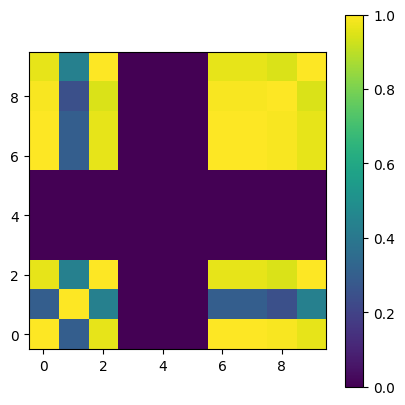

maxNumClusters5
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:2


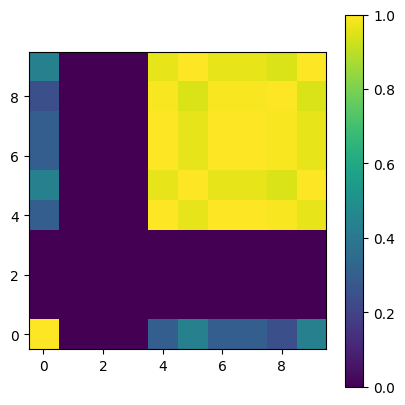

In [56]:
#Draw ground truth
matplotlib.pyplot.matshow(corr) #invert y-axis to get origo at lower left corner
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

#draw prediction based on ONC
corrNew, clstrsNew, silhNew = clusterKMeansTop(corr)
matplotlib.pyplot.matshow(corrNew)
matplotlib.pyplot.gca().xaxis.tick_bottom()
matplotlib.pyplot.gca().invert_yaxis()
matplotlib.pyplot.colorbar()
matplotlib.pyplot.show()

In [57]:
cluster_lists = []

# Iterate through each cluster and its members
for cluster_number, cluster_indices in clstrsNew.items():
    cluster_list = []

    # Iterate through each index in the cluster
    for idx in cluster_indices:
        trial_number = top_trials[idx].number
        cluster_list.append(trial_number)

    cluster_lists.append(cluster_list)

# Print the lists for each cluster
for i, cluster_list in enumerate(cluster_lists):
    print(f"Cluster {i}: {cluster_list}")

Cluster 0: [5, 0, 1, 2]
Cluster 1: [8, 9, 6, 4, 3, 7]


In [58]:
top_10_features_per_cluster = []

for cluster_number, cluster_indices in clstrsNew.items():
    cluster_frequency = {}

    for idx in cluster_indices:
        trial_params = top_trials[idx].params
        for key, value in trial_params.items():
            if value == 1:
                cluster_frequency[key] = cluster_frequency.get(key, 0) + 1

    sorted_cluster_frequency = sorted(cluster_frequency.items(), key=lambda x: x[1], reverse=True)
    top_10_features_cluster = [feature for feature, _ in sorted_cluster_frequency[:10]]
    top_10_features_per_cluster.append(top_10_features_cluster)
    print(f"Top 10 features for Cluster {cluster_number}: {top_10_features_cluster}")

Top 10 features for Cluster 0: [18, 4, 9, 25, 30, 5, 7, 8, 10, 20]
Top 10 features for Cluster 1: [3, 4, 5, 10, 17, 20, 29, 2, 6, 9]


In [59]:
top_10_features_per_cluster

[[18, 4, 9, 25, 30, 5, 7, 8, 10, 20], [3, 4, 5, 10, 17, 20, 29, 2, 6, 9]]

In [ ]:
top10_feat = pd.DataFrame(top_10_features_per_cluster)

In [60]:
selected_columns_cluster = []
selected_columns_cluster_with_info = []
for item in top_10_features_per_cluster:
  selected_columns = new_df_no_close_col.iloc[:, item]
  selected_columns_cluster.append(selected_columns)
  # Add the required columns to the existing selected columns for each cluster
  selected_columns_with_info = pd.concat([data[[ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0']], selected_columns], axis=1)
  selected_columns_cluster_with_info.append(selected_columns_with_info)

In [61]:
selected_columns_cluster

[        un_distributed_income  share_holder_income       roa  \
 0                 6632.500000          1238.636364  0.012818   
 1                 6632.500000          1238.636364  0.012818   
 2                 6632.500000          1238.636364  0.012818   
 3                 6632.500000          1238.636364  0.012818   
 4                 6632.500000          1238.636364  0.012818   
 ...                       ...                  ...       ...   
 125204           29611.083333          4058.666667  0.017333   
 125205           29611.083333          4058.666667  0.017333   
 125206           29611.083333          4058.666667  0.017333   
 125207           29611.083333          4058.666667  0.017333   
 125208           29611.083333          4058.666667  0.017333   
 
         net_profit_margin      roce  operation_income  price_to_book  \
 0                0.346044  0.152074       2704.090909       1.936364   
 1                0.346044  0.152074       2704.090909       1.936364   

# Model selection

## Custom Early Stopping

In [62]:
from xgboost import callback
import pickle

In [63]:
min_delta = 0.0001
patience = 30


class CustomEarlyStopping(callback.TrainingCallback):
    def __init__(self, min_delta, patience, verbose=False):
        super().__init__()
        self.min_delta = min_delta
        self.patience = patience
        self.verbose = verbose
        self.best_score = np.inf
        self.wait = 0
        self.stopped_epoch = 0

    def after_iteration(self, model, epoch, evals_log):
        if not evals_log:
            return False
        metric_name = next(iter(evals_log['validation_0']))
        score = evals_log['validation_0'][metric_name][-1]
        if score < (self.best_score - self.min_delta):
            self.best_score = score
            self.wait = 0
        else:
            self.wait += 1
            if self.wait >= self.patience:
                if self.verbose:
                    print(f"\nStopping. Best score: {self.best_score}")
                self.stopped_epoch = epoch
                return True
        return False

    def get_best_score(self):
        return self.best_score

## Hyperparameter Tuning

In [65]:
# Các cột không phải indicators
non_indicator_columns = [ 'Open', 'High', 'Low', 'Close', 'Volume', 'Return','Unnamed: 0']

# Hàm để lấy các cột indicators từ DataFrame (bỏ qua các cột không phải indicators)
def get_indicator_columns(df, non_indicators):
    return [col for col in df.columns if col not in non_indicators]

# Tạo list mới cho các DataFrame đã sắp xếp
sorted_selected_columns_cluster_with_info = []

# Duyệt qua list_df2 để sắp xếp lại list_df1
for df2 in selected_columns_cluster:
    # Lấy danh sách các cột indicators từ DataFrame trong list_df2
    indicator_columns_df2 = df2.columns.tolist()

    # Tìm DataFrame trong list_df1 có danh sách indicators khớp với df2
    for df1 in selected_columns_cluster_with_info:
        indicator_columns_df1 = get_indicator_columns(df1, non_indicator_columns)

        # Nếu danh sách cột indicators của df1 khớp với df2, thêm df1 vào list đã sắp xếp
        if indicator_columns_df1 == indicator_columns_df2:
            sorted_selected_columns_cluster_with_info.append(df1)
            break

In [77]:
def objective_params(trial, X_train, X_valid, y_train, y_valid, y_close, train_data_X_train, train_data_X_valid):
    # Define the hyperparameter search space
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'n_estimators': 8000,  # does not matter, think of it as max epochs, and we stop the model based on early stopping, so any extremely high number works
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),  # can't comment, never played with that
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),  # you dont want to sample less than 50% of your data
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),  # you dont want to sample less than 30% of your features pr boosting round
        }


    # Check duplication and skip if it's detected.
    for t in trial.study.trials:
        if t.state != optuna.trial.TrialState.COMPLETE:
            continue
        if t.params == trial.params:
            return np.nan #t.values  # Return the previous value without re-evaluating i

    custom_early_stopping_instance = CustomEarlyStopping(min_delta=min_delta, patience=patience, verbose=True)
    selected_features = X_train.columns

    # Train the model
    model = xgb.XGBRegressor(**params, callbacks=[custom_early_stopping_instance])
    model.fit(X_train, y_train)
    # train_data_X_valid=backtest_data(train_data_X_valid)
    stats= run_model_backtest( train_data_X_train,selected_features,model,0)
    stats1= run_model_backtest(  train_data_X_valid,selected_features,model,0)
    ret=stats['Return [%]']

    volatility=stats['Volatility (Ann.) [%]']
    ret1=stats1['Return [%]']

    volatility1=stats1['Volatility (Ann.) [%]']
    try: sharpe=ret/volatility
    except: sharpe=0
    try: sharpe1=ret1/volatility1
    except: sharpe1=0
    trade=stats1['# Trades']
    # Save trade value in the trial object for later access
    trial.set_user_attr('trade', trade)
    try:
        gs= (abs((abs(sharpe / sharpe1))-1))
    except:
        gs=0
    return ret,volatility,gs

In [78]:
sorted_selected_columns_cluster_with_info

[]

In [79]:
best_params_list = []
for idx, data_item in enumerate(selected_columns_cluster):


    info_train_cols, _ = split_data(selected_columns_cluster_with_info[idx])
    train_cols, _ = split_data(data_item)
    optuna_data = scale_data(train_cols)

    temp= info_train_cols.drop(['Close', 'Open','High','Low','Volume', 'return','Unnamed: 0'], axis=1)

    info_optuna_data = scale_data(temp)
    temp= pd.concat([info_train_cols[[ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0']], info_optuna_data], axis=1)
    temp.set_index('Unnamed: 0', inplace=True)
    temp.index.name = 'datetime'
    temp.index = pd.to_datetime(temp.index)
    X_train, X_valid, y_train, y_valid = train_test_split(optuna_data,
                                                            train_data['return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    train_data_X_train, train_data_X_valid, train_data_y_train, train_data_y_valid = train_test_split(temp,
                                                            train_data['return'],
                                                            test_size=0.5,
                                                            shuffle=False)
    study = optuna.create_study(directions=['maximize', 'minimize', 'minimize'])

    unique_trials = 1
    while unique_trials > len(set(str(t.params) for t in study.trials)):
        study.optimize(lambda trial: objective_params(trial, X_train, X_valid, y_train, y_valid, train_data['Close'], train_data_X_train, train_data_X_valid), n_trials=1)
        study.trials_dataframe().fillna(0).sort_values('values_0').to_csv(f'hypertuning{idx}.csv')
        joblib.dump(study, f'{unique_trials}hypertuningcluster{idx}.pkl')

    # Retrieve all trials
    trials = study.trials

    completed_trials = [t for t in study.trials if t.values is not None]

    # Sort trials based on objective values
    completed_trials.sort(key=lambda trial: trial.values, reverse=True)

    # Select top 1 trials
    params = completed_trials[0].params
    best_params_list.append(params)

    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)

    model.save_model(f'best_in_cluster_{idx}.json')
with open('best_params_list.pkl', 'wb') as f:
  pickle.dump(best_params_list, f)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-10-16 06:50:50,860] A new study created in memory with name: no-name-f8328011-c313-472a-8f6a-7114bf656e3e
[I 2024-10-16 06:51:10,251] Trial 0 finished with values: [0.0, 0.0, 0.0] and parameters: {'max_depth': 11, 'learning_rate': 0.02943925411608978, 'min_child_weight': 10, 'subsample': 0.6304073366192922, 'colsample_bytree': 0.4231472833104397}.
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
[I 2024-10-16 06:51:10,569] A new study created in memory with name: no-name-2a011398-af41-46f9-9cc4-5bef430bd8d1
[I 2024-10-16 06:51:37,195] Trial 0 finished with values: [-10

In [ ]:
# trials = study.trials
# trials.sort(key=lambda trial: trial.values, reverse=True)
# study.trials_dataframe().sort_values('values_0', ascending=False)

# Test and save result

In [80]:
train_data, hold_out = split_data(data)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [82]:
return_data = []
sharpe_list = []
volatility=[]
result = None

train_data, hold_out = split_data(data)


for idx, data_item in enumerate(selected_columns_cluster):
    _, hold_out_cols = split_data(data_item)
    # _, info_hold_out_cols= split_data(sorted_selected_columns_cluster_with_info[idx])
    # _, test_cols = split_data(data_item)
    # optuna_data = scale_data(test_cols)

    temp= hold_out.drop(['Close', 'Open','High','Low','Volume', 'return','Unnamed: 0'], axis=1)

    info_optuna_data = scale_data(temp)
    temp= pd.concat([hold_out[[ 'Open','High','Low','Close','Volume', 'return','Unnamed: 0']], info_optuna_data], axis=1)
    temp.set_index('Unnamed: 0', inplace=True)
    temp.index.name = 'datetime'
    temp.index = pd.to_datetime(temp.index)

    xbg_reg = xgb.XGBRegressor()
    # Create and train model
    xbg_reg.load_model(f"best_in_cluster_{idx}.json")
    selected_features = optuna_data.columns
    # Make predictions
    # hold_out_cols.columns = optuna_data.columns
    test_data=temp
    stats1= run_model_backtest( test_data,selected_features,xbg_reg,0.005)
    print(stats1)
    return_data.append(stats1['Return [%]'])
    sharpe_list.append(stats1['Sharpe Ratio'])
    volatility.append(stats1['Volatility (Ann.) [%]'])


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Start                     2022-08-26 09:15:00
End                       2024-08-30 14:45:00
Duration                    735 days 05:30:00
Exposure Time [%]                         0.0
Equity Final [$]                       3000.0
Equity Peak [$]                        3000.0
Return [%]                                0.0
Buy & Hold Return [%]                2.177413
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Start                     2022-08-26 09:15:00
End                       2024-08-30 14:45:00
Duration                    735 days 05:30:00
Exposure Time [%]                   25.103029
Equity Final [$]                    2019.9805
Equity Peak [$]                        3000.0
Return [%]                         -32.667317
Buy & Hold Return [%]                2.177413
Return (Ann.) [%]                  -17.491538
Volatility (Ann.) [%]               13.438334
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -33.844883
Avg. Drawdown [%]                  -33.844883
Max. Drawdown Duration      735 days 05:27:00
Avg. Drawdown Duration      735 days 05:27:00
# Trades                                   58
Win Rate [%]                        31.034483
Best Trade [%]                       4.085343
Worst Trade [%]                      -3.05375
Avg. Trade [%]                    

In [83]:
#Top 10 feature into list
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)
print(feature)

['18 4 9 25 30 5 7 8 10 20', '3 4 5 10 17 20 29 2 6 9']


In [84]:
feature=[]
for i in top_10_features_per_cluster:
    listToStr = ' '.join([str(elem) for elem in i])
    feature.append(listToStr)

name=[]
for i in range(len(selected_columns_cluster)):
  name.append( 'Cluster '+ str(i))

dict = {'Top 10 Feature' : feature, 'Best params': best_params_list, 'Best sharpe':sharpe_list,"Return [%]": return_data,'Volatility':volatility}
df_result = pd.DataFrame(dict)
# df_result.to_csv('xgb_result.csv')
df_result

,Top 10 Feature,Best params,Best sharpe,Return [%],Volatility
0,18 4 9 25 30 5 7 8 10 20,"{'max_depth': 11, 'learning_rate': 0.029439254...",NaN,0.000000,0.000000
1,3 4 5 10 17 20 29 2 6 9,"{'max_depth': 4, 'learning_rate': 0.0445001805...",0.0,-32.667317,13.438334
